In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('drive/MyDrive/DL202010770/Lab05/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

from plot_output import plot_latent_space, plot_denoising_results, gan_images

In [6]:
# 데이터 로드 및 전처리
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

11490434/11490434 [==============================] - 2s 0us/step


In [7]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

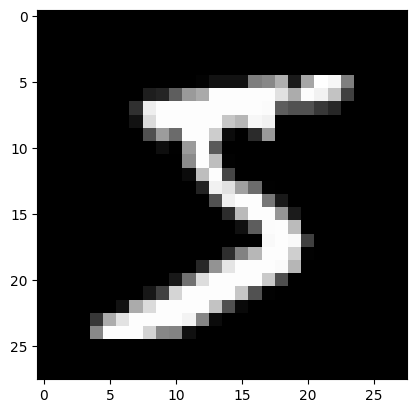

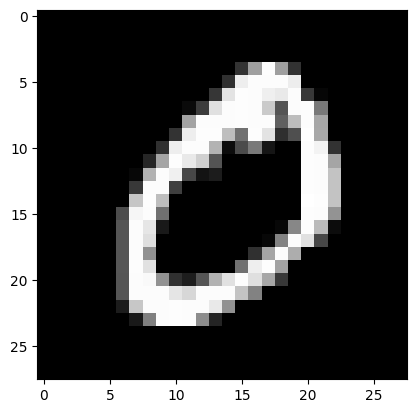

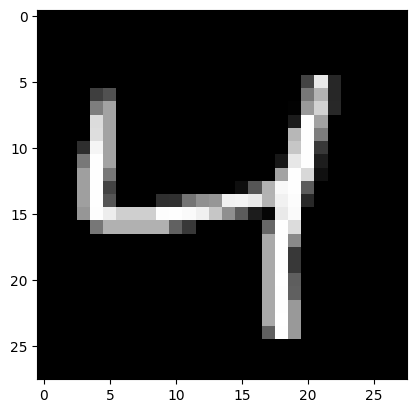

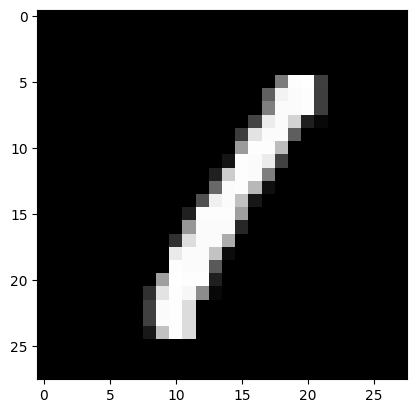

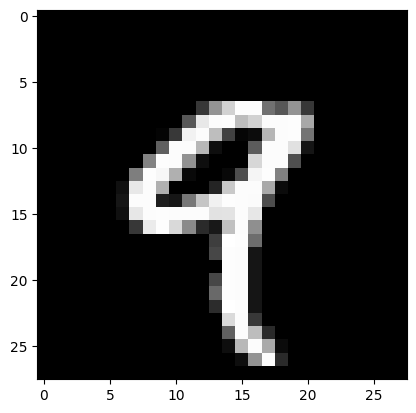

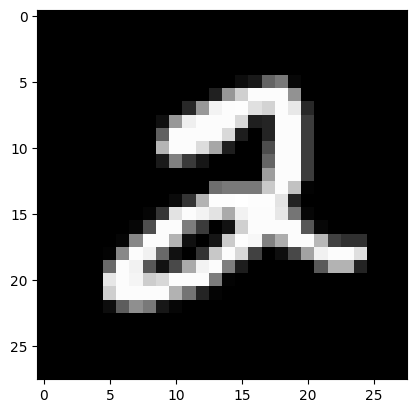

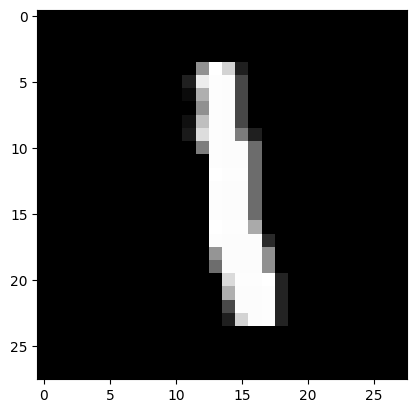

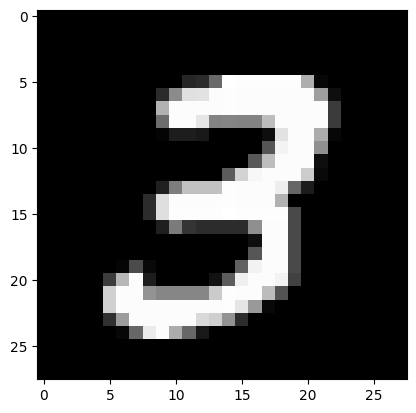

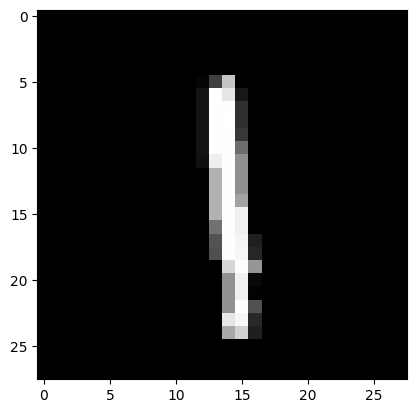

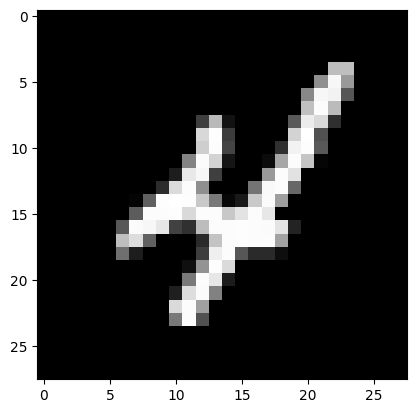

In [8]:
for idx in range(10):
  plt.imshow(x_train[idx], cmap='gray')
  plt.show()

# 1. Autoencoder

In [9]:
# 입력 데이터 차원
input_dim = 28*28  # 28x28 픽셀 이미지가 1차원 벡터로 변환된 형태
encoding_dim = 32  # 잠재 공간의 차원 (숫자 바꾸면서 성능 비교해보셔도 됩니다)

In [10]:
# 인코더 정의
encoder = Sequential([
    Flatten(input_shape=(28, 28)),  # 입력 이미지를 1차원 벡터로 변환
    Dense(encoding_dim, activation='relu')  # 인코딩 레이어
])

# 디코더 정의
decoder = Sequential([
    Dense(input_dim, activation = 'sigmoid', input_shape=(encoding_dim,)), # 디코딩 레이어
    Reshape((28, 28))  # 1차원 벡터를 다시 28x28 이미지로 변환
])

# 오토인코더 모델 정의
autoencoder = Sequential([encoder, decoder])

# 손실 함수로 binary_crossentropy 사용
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
# 모델 훈련
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 7s 5ms/step - loss: 0.2753 - val_loss: 0.1905
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1697 - val_loss: 0.1521
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1440 - val_loss: 0.1341
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1294 - val_loss: 0.1220
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1189 - val_loss: 0.1131
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1114 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1062 - val_loss: 0.1028
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1024 - val_loss: 0.0996
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0996 - val_loss: 0.0971
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0976 - val_loss: 0.0955

In [12]:
# 재구성 결과 확인
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 1ms/step


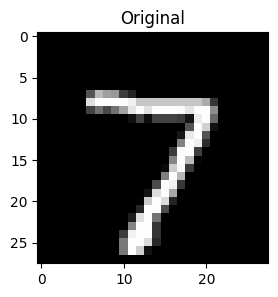

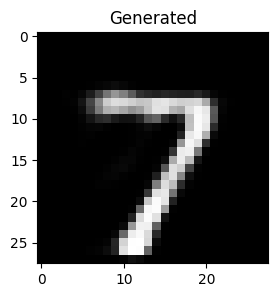

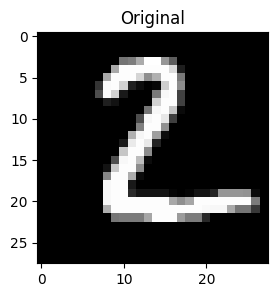

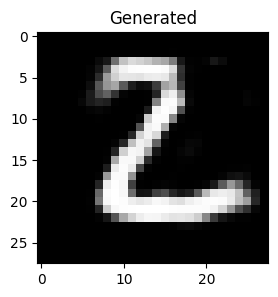

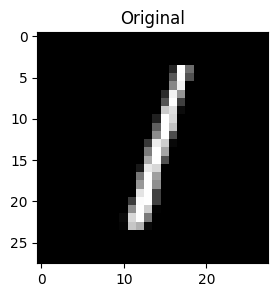

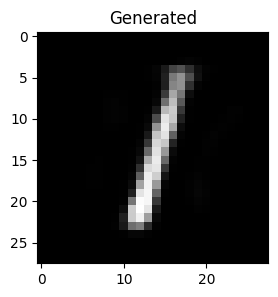

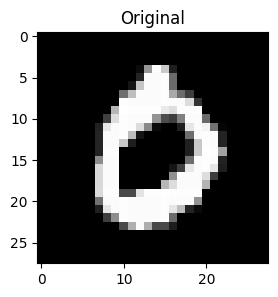

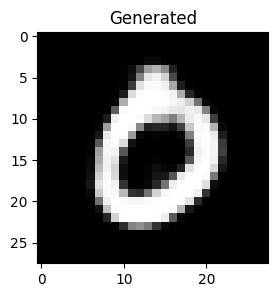

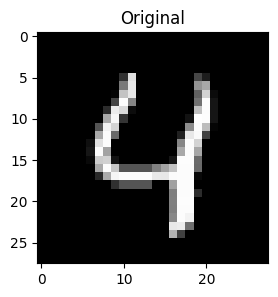

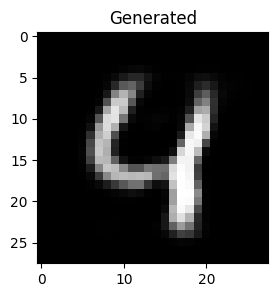

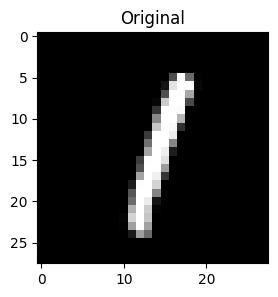

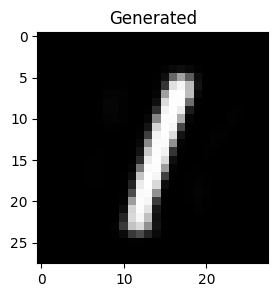

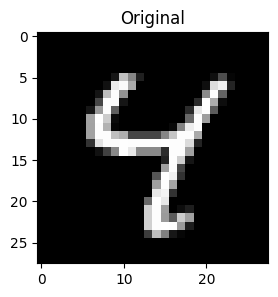

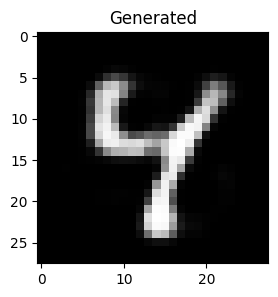

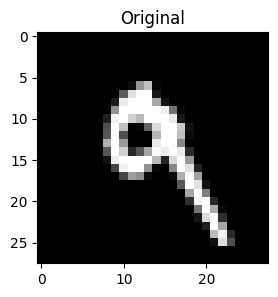

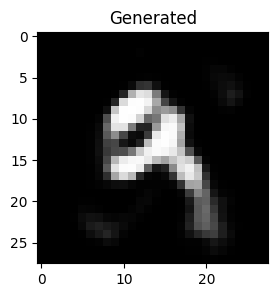

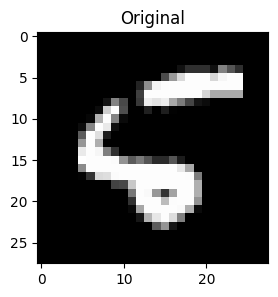

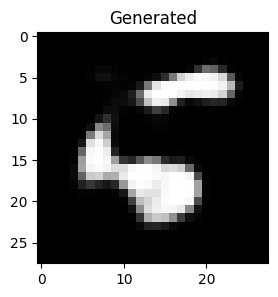

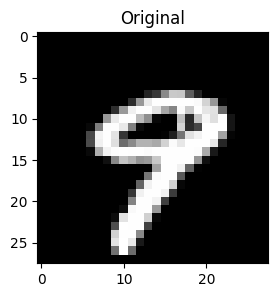

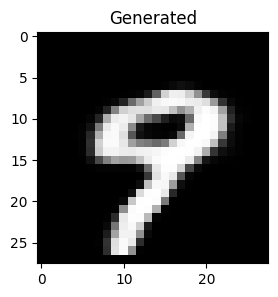

In [13]:
n = 10  # 시각화할 이미지 개수
for i in range(n):
  # 원본 이미지
  plt.figure(figsize=(3,3))
  plt.title("Original")
  plt.imshow(x_test[i], cmap='gray')
  plt.show()
  # 재구성된 이미지
  plt.figure(figsize=(3,3))
  plt.title("Generated")
  plt.imshow(decoded_imgs[i], cmap='gray')
  plt.show()

# 2. VAE

In [14]:
latent_dim = 2

# 인코더 정의
encoder = Sequential([
    Input(shape=(28, 28)),  # 입력 이미지 크기
    Flatten(),  # 입력 이미지를 1차원 벡터로 변환
    Dense(128, activation = 'relu'),  # 중간 레이어
    Dense(latent_dim + latent_dim)  # z_mean과 z_log_var를 함께 출력
], name='encoder')
encoder.summary()


# 샘플링 레이어를 정의합니다
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = tf.split(inputs, num_or_size_splits=2, axis=1)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# 디코더 정의
decoder = Sequential([
    Input(shape=(latent_dim,)),  # 잠재 공간 입력
    Dense(128, activation='relu'),  # 중간 레이어
    Dense(28*28, activation ='sigmoid'),  # 출력 레이어
    Reshape((28, 28))  # 1차원 벡터를 다시 28x28 이미지로 변환
], name='decoder')
decoder.summary()

# VAE 모델 정의
vae = Sequential([encoder, Sampling(), decoder], name='vae')

# 손실 함수 정의
def vae_loss(inputs, outputs, z_mean_log_var):
    z_mean, z_log_var = tf.split(z_mean_log_var, num_or_size_splits=2, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, outputs)) * 28 * 28
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    return reconstruction_loss + kl_loss

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer, loss=lambda inputs, outputs: vae_loss(inputs, outputs, encoder(inputs)))
# 모델 학습
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 100996 (394.52 KB)
Trainable params: 100996 (394.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               384       
                                                                 
 d

1/1 [==============================] - 0s 17ms/step


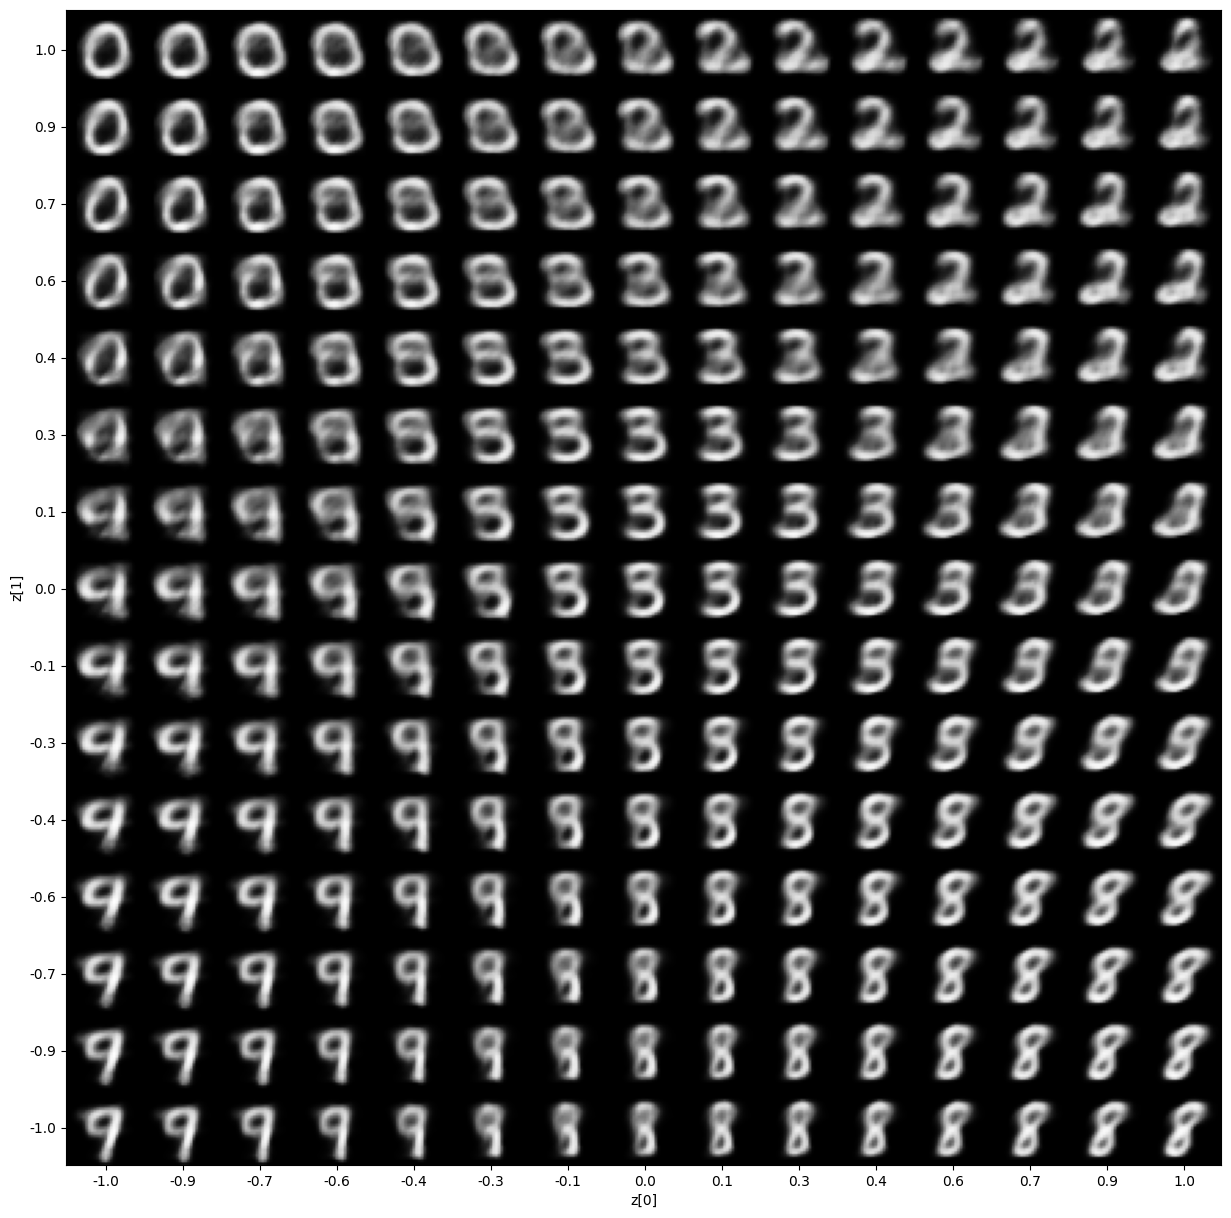

In [15]:
plot_latent_space(vae)

# 3. GAN

In [16]:
x_train = x_train.reshape(-1, 28, 28, 1)

In [17]:
# 생성기 모델 정의
def build_generator():
    model = Sequential([
        Dense(128, activation = 'relu', input_dim = 100),
        Dense(784, activation = 'sigmoid'),
        Reshape((28, 28, 1))  # 784차원 벡터를 28x28 이미지로 변환
    ])
    return model

# 판별기 모델 정의
def build_discriminator():
    model = Sequential([
        layers.Flatten(input_shape=(28,28)),
        Dense(128, activation='relu', input_dim=784),
        Dense(1, activation='sigmoid')
    ])
    return model

# GAN 모델 구축 및 학습
def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

# 모델 생성
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# 하이퍼파라미터 설정
batch_size = 128
epochs = 10000
sample_interval = 1000
noise_dim = 100



In [18]:
# 학습 과정
def train(generator, discriminator, gan, x_train, batch_size, epochs, noise_dim, sample_interval):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # 판별기 훈련
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_imgs = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        discriminator.train_on_batch(real_imgs, real_labels)
        discriminator.train_on_batch(fake_imgs, fake_labels)

        # 생성기 훈련
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        valid_y = np.ones((batch_size, 1))

        gan.train_on_batch(noise, valid_y)

        # 주기적으로 이미지 샘플링
        if epoch % sample_interval == 0:
            gan_images(generator, epoch, noise_dim)

1/1 [==============================] - 0s 53ms/step


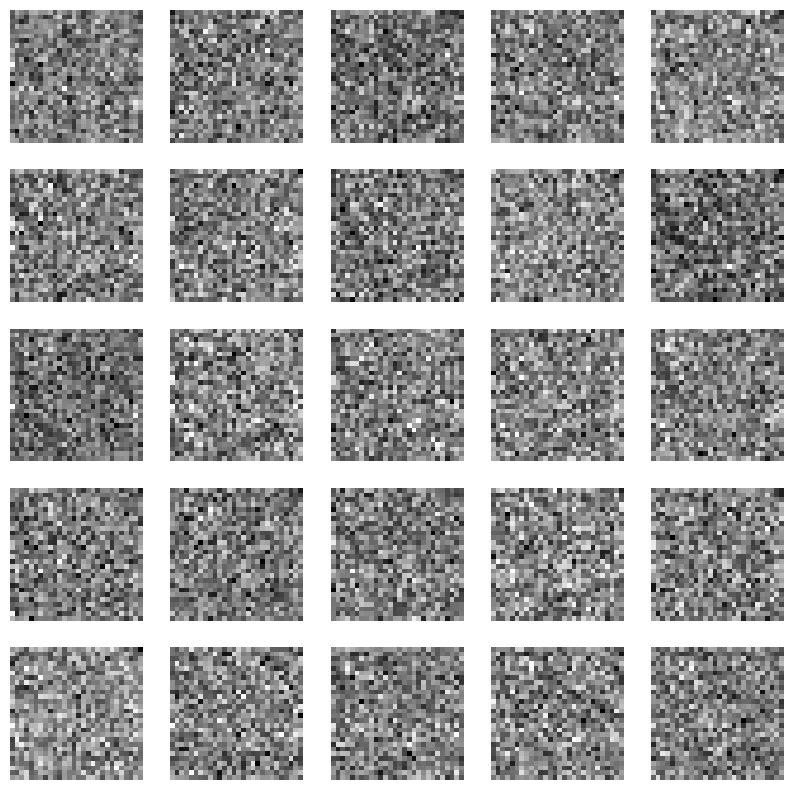

1/1 [==============================] - 0s 28ms/step


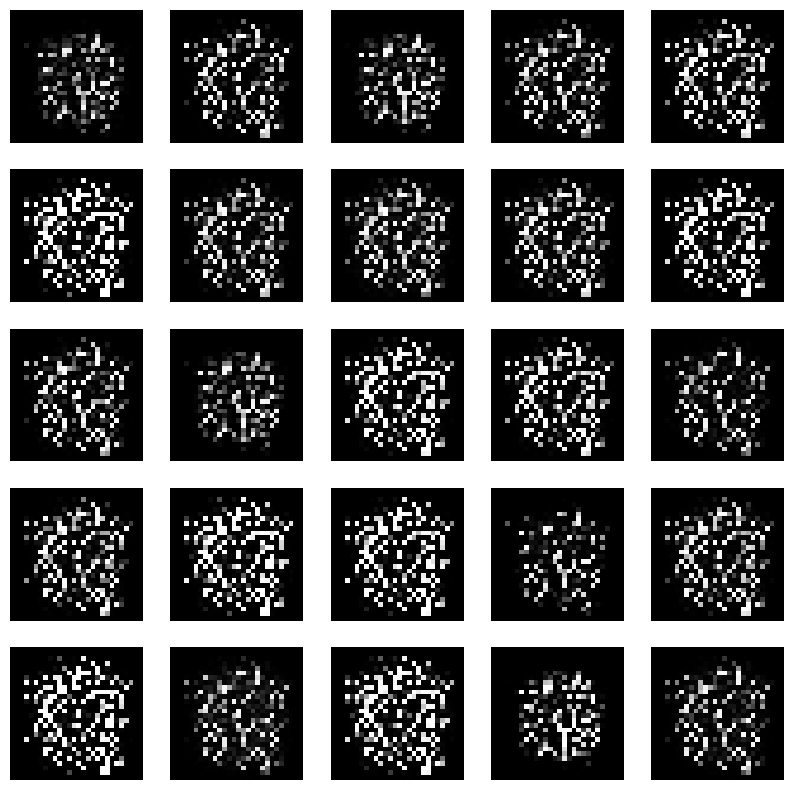

1/1 [==============================] - 0s 17ms/step


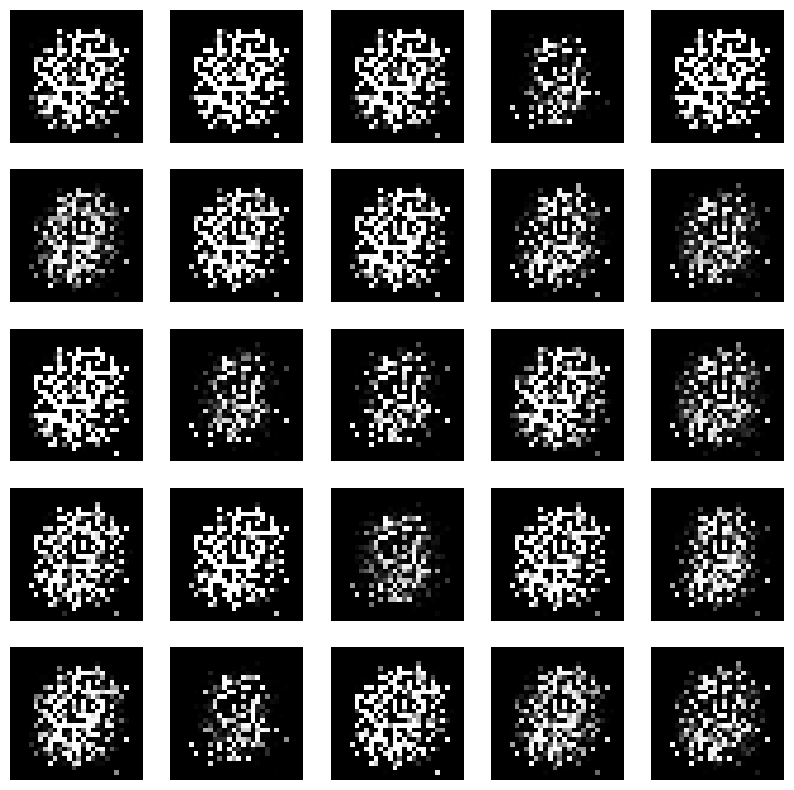

1/1 [==============================] - 0s 18ms/step


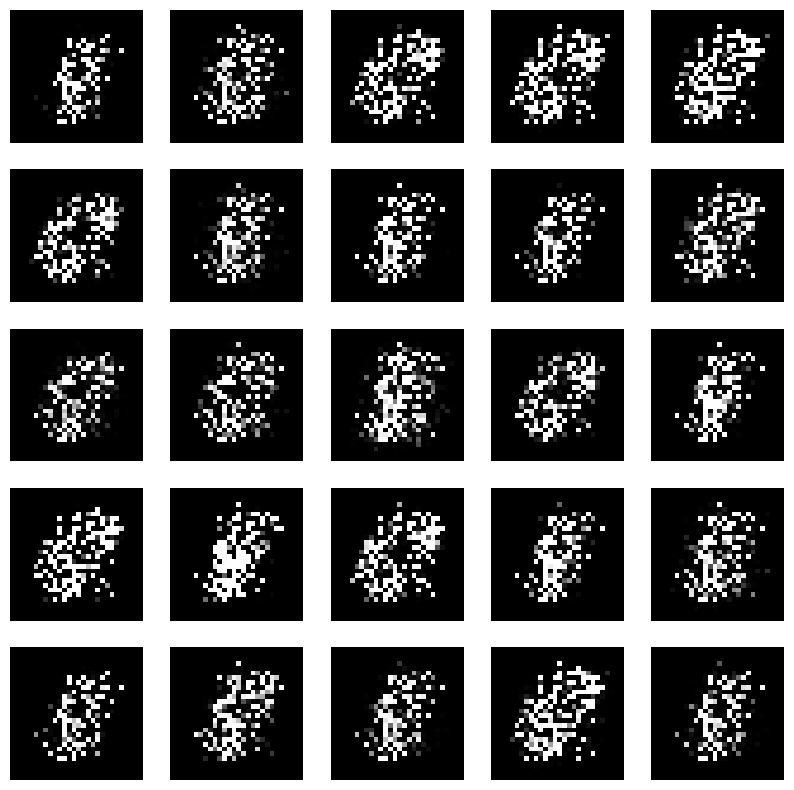

1/1 [==============================] - 0s 24ms/step


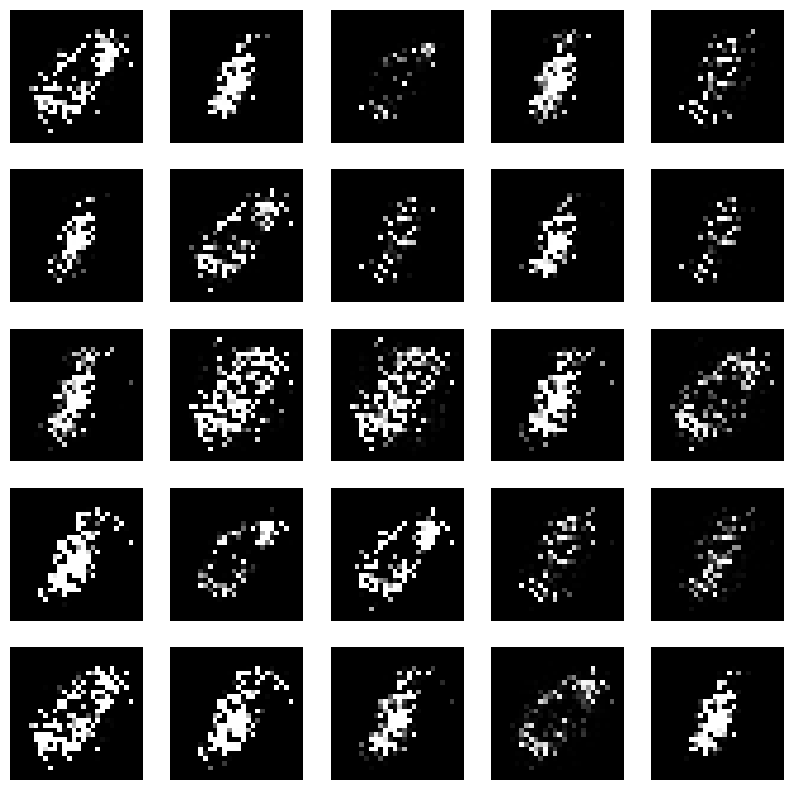

1/1 [==============================] - 0s 33ms/step


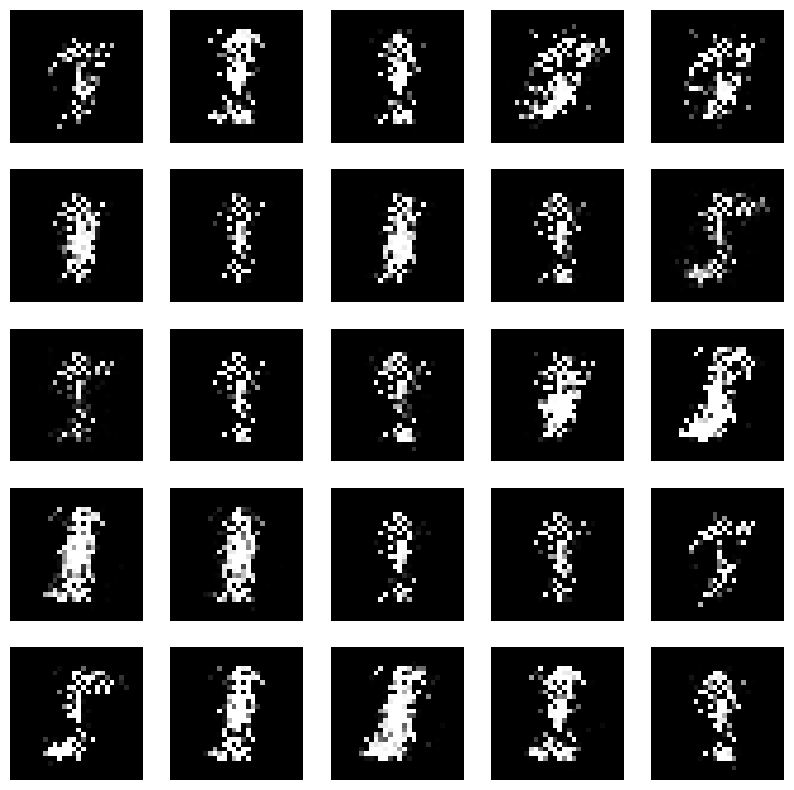

1/1 [==============================] - 0s 17ms/step


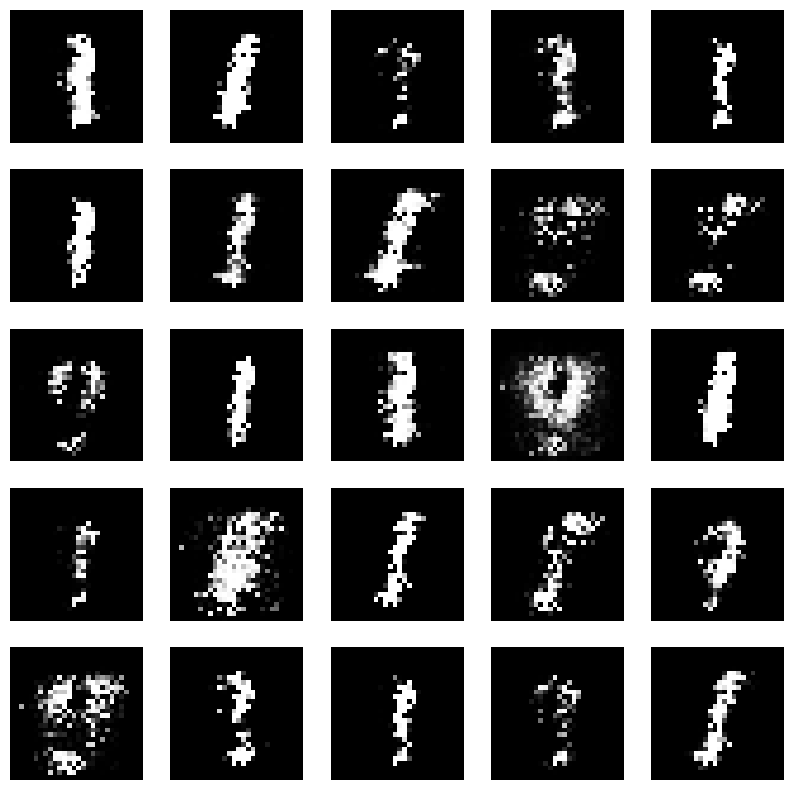

2/2 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

In [19]:
train(generator, discriminator, gan, x_train, batch_size, epochs, noise_dim, sample_interval)

# 4. Diffusion

Epoch 1/10
469/469 [==============================] - 7s 7ms/step - loss: 0.1628 - val_loss: 0.1117
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1105 - val_loss: 0.1083
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1085 - val_loss: 0.1071
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1072 - val_loss: 0.1060
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1059 - val_loss: 0.1044
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1046 - val_loss: 0.1034
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1037 - val_loss: 0.1025
Epoch 8/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1029 - val_loss: 0.1019
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1023 - val_loss: 0.1015
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


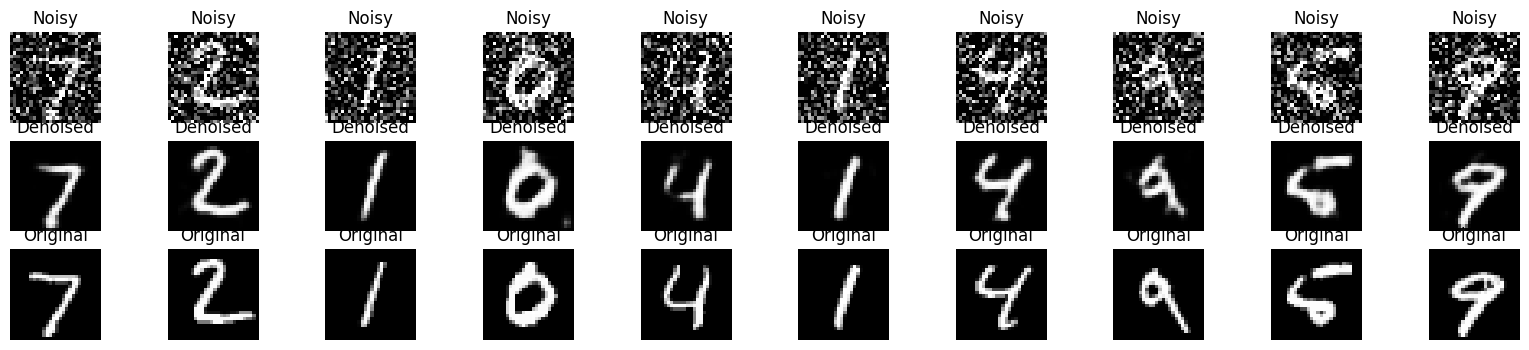

In [20]:
# 노이즈 추가 함수
def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * np.random.normal(size=data.shape)
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

# 노이즈 제거 모델 정의
def build_denoising_model():
    model = tf.keras.Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model


# 노이즈 데이터 생성
noise_factor = 0.5
x_train_noisy = add_noise(x_train, noise_factor)
x_test_noisy = add_noise(x_test, noise_factor)

# 모델 학습
denoising_model = build_denoising_model()
denoising_model.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))

# 노이즈 제거 결과 시각화
plot_denoising_results(denoising_model, x_test_noisy, x_test)

# +추가 실습!

In [21]:
!pip install diffusers transformers scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00


In [22]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# 모델 및 토크나이저 로드
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = StableDiffusionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in yo

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

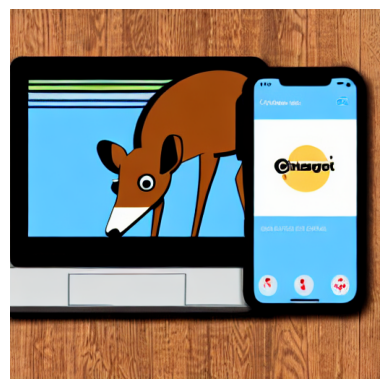

In [27]:
# 텍스트 프롬프트를 사용하여 이미지 생성
prompt = "lOGO ABOUT CHATBOT"
with torch.autocast("cuda"):
    image = pipeline(prompt)[0]
# 이미지 시각화
plt.imshow(image[0])
plt.axis("off")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

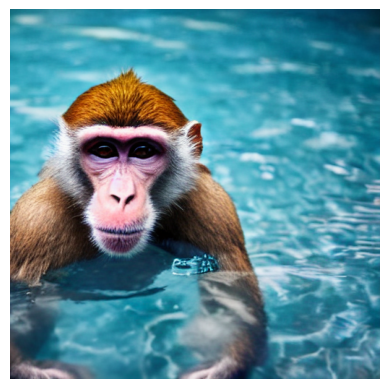

In [24]:
# 텍스트 프롬프트를 사용하여 이미지 생성
prompt = "A monkey in a swimming pool"
with torch.autocast("cuda"):
    image = pipeline(prompt)[0]

# 이미지 시각화
plt.imshow(image[0])
plt.axis("off")
plt.show()